# Serial Position Curve for first/second presentation

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import cmlreaders as cml
import cmldask.CMLDask as da
import os
import glob
import pickle
import traceback
import numpy as np
import cmlreaders as cml
import pandas as pd
import mne
import matplotlib.pyplot as plt
import math

from pandas import MultiIndex

In [2]:
exp = 'ltpDelayRepFRReadOnly'
df = cml.get_data_index()
df = df[df['experiment']==exp]
subjs = np.unique(df['subject'])
subjs = subjs[:-1]
ix = cml.get_data_index()
exp_ix = ix.query('experiment == @exp')
biosem_Ch = np.array([4,5,6,17,30,31,33,34,35,49,50,62,63,65,66,67,74,75,87,88,97,98,99,107,108,111,112,123])
subjs

array(['LTP501', 'LTP502', 'LTP503', 'LTP504', 'LTP505', 'LTP507',
       'LTP508', 'LTP509', 'LTP510', 'LTP511', 'LTP513', 'LTP514',
       'LTP515', 'LTP516', 'LTP518', 'LTP519', 'LTP520', 'LTP521',
       'LTP522', 'LTP524', 'LTP525', 'LTP527', 'LTP528', 'LTP530',
       'LTP531', 'LTP533', 'LTP534', 'LTP535', 'LTP536', 'LTP537',
       'LTP538', 'LTP540', 'LTP541', 'LTP542', 'LTP543', 'LTP544',
       'LTP545', 'LTP546', 'LTP547', 'LTP549', 'LTP550', 'LTP551',
       'LTP552', 'LTP553', 'LTP554', 'LTP555', 'LTP557', 'LTP558',
       'LTP559', 'LTP561', 'LTP562', 'LTP563'], dtype=object)

In [4]:
def compute_SPC(subj):
    df_select = exp_ix[exp_ix['subject']==subj]

    df_select = df[(df['subject']==subj) & (df['experiment']==exp)]
    df_select = df_select[df_select.session < 7]
    nSess = len(df_select)
    SPC_single = [[]]*min([6, nSess])
    SPC_first = []
    SPC_second = []
    
    pres_counts = np.array([])
    first_counts = np.array([])
    second_counts = np.array([])
    half_counts = np.array([])
    for i in range(0, min([6, nSess])):
        sess_df = df_select.iloc[i]
        reader = cml.CMLReader(subject=sess_df.subject,
                       session=sess_df.session,
                       experiment=sess_df.experiment)
        evs = reader.load('task_events')
        word_evs = evs[evs['type']=='WORD']  
        recalled = np.array(word_evs.recalled)
        serial_pos = np.array(word_evs.serialpos)
        repeats = np.array(word_evs.repeats)
        singSPC = []
        enc_item = np.array(word_evs.item_num)
        enc_list = np.array(word_evs.list)
        for k in range(0, 18):           
            num_rec = sum(recalled[(serial_pos == k) & (repeats == 1)])
            num_pres = len(recalled[(serial_pos == k) & (repeats == 1)])
            singSPC.append(num_rec/num_pres)
            
        SPC_single[i] = singSPC
                
    return np.nanmean(SPC_single, axis = 0)
        
        

In [4]:

SPCsing = [[]]*len(subjs)
SPCfirst = [[]]*len(subjs)
SPCsecond = [[]]*len(subjs)
for i in range(len(subjs)):
    try:
        # SPCsing[i], SPCfirst[i], SPCsecond[i] = compute_SPC(subjs[i])
         SPCsing[i]= compute_SPC(subjs[i])
    except (FileNotFoundError, RuntimeError, TypeError, NameError, ValueError, AssertionError, IndexError, ZeroDivisionError):
        print("Error! Subject " + str(subjs[i]))
        continue

SPCsing = [ele for ele in SPCsing if ele != []]


Error! Subject LTP545
Error! Subject LTP547


/tmp/ipykernel_86204/3535124560.py:12: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  SPCsing = [ele for ele in SPCsing if ele != []]


In [24]:
def SP_repeats(subj):
    df_select = exp_ix[exp_ix['subject']==subj]

    df_select = df[(df['subject']==subj) & (df['experiment']==exp)]
    df_select = df_select[df_select.session < 7]
    nSess = len(df_select)
    SPC_rep = [[]]*min([6, nSess])

    pres_counts = np.array([])
    repSP = []

    for i in range(0, min([6, nSess])):
        sess_df = df_select.iloc[i]
        reader = cml.CMLReader(subject=sess_df.subject,
                       session=sess_df.session,
                       experiment=sess_df.experiment)
        evs = reader.load('task_events')
        word_evs = evs[evs['type']=='WORD']  
        lists = np.array(word_evs.list)
        serial_pos = np.array(word_evs.serialpos)
        repeats = np.array(word_evs.repeats)
        repSP = []
        enc_item = np.array(word_evs.item_num)
        enc_list = np.array(word_evs.list)
        for k in range(max(lists)): 
            encwords = enc_item[enc_list == k]
            reps = repeats[lists == k]
            encSP = serial_pos[enc_list == k]
            for n in range(0, 18):
                if reps[n] == 2:
                    serialpos = encSP[encwords == encwords[n]]
                    if serialpos[1] > 12:
                        repSP = np.append(repSP, serialpos[1])
    return np.nanmean(repSP), np.std(repSP)
    

In [27]:
SPCrepeat = [[]]*len(subjs)
for i in range(len(subjs)):
    try:
        SPCrepeat[i] = SP_repeats(subjs[i])
    except (FileNotFoundError, RuntimeError, TypeError, NameError, ValueError, AssertionError, IndexError, ZeroDivisionError):
        print("Error! Subject " + str(subjs[i]))
        continue

SPCrepeat = [ele for ele in SPCrepeat if ele != []]

In [ ]:
def Check_repSP(subj):
    df_select = exp_ix[exp_ix['subject']==subj]

    df_select = df[(df['subject']==subj) & (df['experiment']==exp)]
    df_select = df_select[df_select.session < 7]
    nSess = len(df_select)
    SPC_rep = [[]]*min([6, nSess])

        for k in range(max(lists)): 
            encwords = enc_item[enc_list == k]
            reps = repeats[lists == k]
            encSP = serial_pos[enc_list == k]
            for n in range(7, 10):
                if reps[n] == 2:
                    serialpos = encSP[encwords == encwords[n]]
                    repSP = np.append(repSP, serialpos[1])
            
        SPC_rep[i] = repSPC

In [32]:
def loftus_masson(dat):
    
    #     This method can be used if one does not assume equal variance between
    #  groups.
    #
    #  err = loftus_masson(dat)
    #
    #  INPUTS:
    #     dat:  [subjects X groups] matrix of dependent measures.
    #
    #  OUTPUTS:
    #      err:  [1 X groups] vector of error values.


    #normalize the data
    grandMean = np.nanmean(dat);
    subjmean = np.nanmean(dat, axis = 1);
    subjAll = [[]]*len(dat)
    for i in range(len(subjmean)):
        subjAll[i] = [subjmean[i]]*len(dat[0])

    dat = dat - (subjAll - grandMean);
    
    Err = []
    for i in range(0,len(dat[0])):
        Temp = []
        for j in range(0,len(dat)):
            if math.isnan(dat[j][i]) == False:
                Temp.append(dat[j][i]) 
        Err.append(np.std(Temp)/(math.sqrt(len(dat))) * math.sqrt(len(dat[0])/(len(dat[0]) - 1)))   
        
    return Err

In [222]:
errSing = loftus_masson(SPCsing) 
errRepeat = loftus_masson(SPCrepeat)

errSing = [el * 1.96 for el in errSing]
errRepeat = [el * 1.96 for el in errRepeat]

In [23]:
errSing = [el * 1.96 for el in errSing]

NameError: name 'SPCrepeat' is not defined

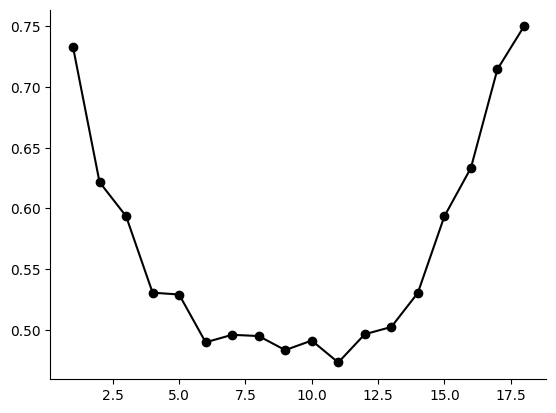

In [40]:
fix, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(range(1,19), np.nanmean(SPCsing, axis = 0), color = 'k', marker='o')
plt.plot(range(1,19), np.nanmean(SPCrepeat, axis = 0), color = [.9, 0, .4], marker='o')
plt.legend(['Single','Repeat'], frameon = False, fontsize = 14)


plt.fill_between(range(1,19), np.nanmean(SPCsing, axis = 0) - errSing, np.nanmean(SPCsing, axis = 0) + errSing, color = 'k', alpha = .1) 
plt.fill_between(range(1,19), np.nanmean(SPCrepeat, axis = 0) - errRepeat, np.nanmean(SPCrepeat, axis = 0) + errRepeat, color = 'purple', alpha = .1) 

# plt.xticks([1, 5, 10, 15], fontsize = 15)
# plt.yticks([0,.2,.4,.6,.8,1], fontsize = 15)

plt.ylim((0, 1))
plt.ylabel('Prob. Recall', fontsize = 18)
plt.xlabel("Serial Position", fontsize = 18)
plt.gca().set_xticks(list(range(1,19)))

In [17]:
Singrec = np.mean(SPCsing, axis = 1)
Reprec = np.mean(SPCrepeat, axis = 1)

In [269]:
errsing = (np.std(Singrec)/math.sqrt(len(Singrec))) * 1.96
errrep = (np.std(Reprec)/math.sqrt(len(Reprec))) * 1.96

In [10]:
from scipy.stats import ttest_ind

single_recs = np.mean(SPCsing, axis = 0)
rep_recs = np.mean(SPCrepeat, axis = 0)

ttest_ind(single_recs, rep_recs, equal_var = True)

TtestResult(statistic=-4.35598823295688, pvalue=0.00038080377332466264, df=18.0)

NameError: name 'Singrec' is not defined

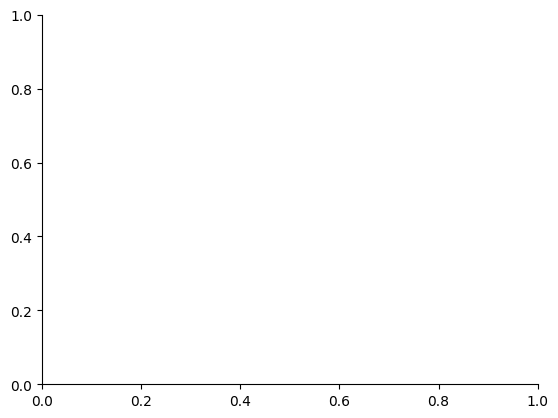

In [38]:
fix, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.bar([1], np.nanmean(Singrec), color = [.5, .5, .5] , width = 1)
plt.bar([2.5], np.nanmean(Reprec), color = [.9, 0, .4], width = 1)
plt.legend(['Single','Repeat'], frameon = False, fontsize = 14)


plt.errorbar([1], [np.nanmean(Singrec)], yerr= errsing, fmt="o", color="k", capsize = 5)
plt.errorbar([2.5], np.nanmean(Reprec), yerr= errrep, fmt="o", color="k", capsize = 5)

plt.ylim((0.3, .62))
plt.ylabel("Prob. Recall", fontsize = 18)
#plt.gca().set_yticks([.495, .499, .503, .507], labels = [.495, .499, .503, .507], fontsize = 12)
plt.gca().set_xticks([1, 2.5], labels = ['Single', 'Repeat'], fontsize = 18)
plt.ylim([0, 1])
plt.title('ISI (1600-4100 ms)')

In [207]:
#proportionately attribute each presentation based on proximity of surrounding recalls
def proportional_attribution(subj):
    df_select = exp_ix[exp_ix['subject']==subj]

    df_select = df[(df['subject']==subj) & (df['experiment']==exp)]
    df_select = df_select[df_select.session < 7]
    nSess = len(df_select)

    SPC_first = []
    SPC_second = []
    
    pres_counts = np.array([])
    rep_counts = 0
    first_counts = np.array([])
    second_counts = np.array([])
    half_counts = np.array([])
    for i in range(0, min([6, nSess])):
        sess_df = df_select.iloc[i]
        reader = cml.CMLReader(subject=sess_df.subject,
                       session=sess_df.session,
                       experiment=sess_df.experiment)
        evs = reader.load('task_events')
        word_evs = evs[evs['type']=='WORD']  
        recalled = np.array(word_evs.recalled)
        serial_pos = np.array(word_evs.serialpos)
        repeats = np.array(word_evs.repeats)

        enc_item = np.array(word_evs.item_num)
        enc_list = np.array(word_evs.list)

        rec_evs = evs[evs['type']=='REC_WORD'] 
        lists = np.array(rec_evs.list)
        repeats = np.array(rec_evs.repeats)
        rec_item =  np.array(rec_evs.item_num)

        for k in range(0, max(lists)): 
            encwords = enc_item[enc_list == k]
            recwords = rec_item[lists == k]
            reps = repeats[lists == k]
            encSP = serial_pos[enc_list == k]
            for n in range(0, len(reps)):
                if reps[n] == 2:
                    serialpos = encSP[encwords == recwords[n]]
                    
                    if len(serialpos) == 0:
                        continue
                    pres_counts = np.append(pres_counts, serialpos)
                    rep_counts = rep_counts + 1


                    if n < (len(reps) - 1):

                        iplusone = encSP[encwords == recwords[n + 1]]

                        firstlags_from = iplusone - serialpos[0]
                        secondlags_from = iplusone - serialpos[1]
                    else:
                        firstlags_from = []
                        secondlags_from = [] 

                    if n > 0:

                        iminusone = encSP[encwords == recwords[n - 1]]    

                        firstlags_to = serialpos[0] - iplusone 
                        secondlags_to = serialpos[1] - iplusone 
                    else:
                        firstlags_to = []
                        secondlags_to = []

                    if (len(firstlags_from) == 0) and (len(firstlags_to) == 0):
                        continue

                    if (len(firstlags_from) > 0) and (len(firstlags_to) > 0):
                        firstlags_av = np.mean([min(abs(firstlags_from)), min(abs(firstlags_to))])
                        secondlags_av = np.mean([min(abs(secondlags_from)), min(abs(secondlags_to))])
                        
                        first_prop = secondlags_av / (firstlags_av + secondlags_av)
                        second_prop = firstlags_av / (firstlags_av + secondlags_av)

                        first_counts = np.append(first_counts, first_prop)
                        second_counts = np.append(second_counts, second_prop)

                    if len(firstlags_from) == 0:

                        first_prop = min(abs(secondlags_to)) / (min(abs(firstlags_to)) + min(abs(secondlags_to)))
                        second_prop = min(abs(firstlags_to)) / (min(abs(firstlags_to)) + min(abs(secondlags_to)))
                        
                        first_counts = np.append(first_counts, first_prop)
                        second_counts = np.append(second_counts, second_prop)

                    if len(firstlags_to) == 0:
                        first_prop = min(abs(secondlags_from)) / (min(abs(firstlags_from)) + min(abs(secondlags_from)))
                        second_prop = min(abs(firstlags_from)) / (min(abs(firstlags_from)) + min(abs(secondlags_from)))
                        
                        first_counts = np.append(first_counts, first_prop)
                        second_counts = np.append(second_counts, second_prop)


                            
    
    first_counts = [el for el in first_counts if np.isnan(el) == False]
    second_counts = [el for el in second_counts if np.isnan(el) == False]
    firstrecs = sum(first_counts)
    secondrecs = sum(second_counts)

        
    SPC_first = firstrecs/rep_counts
    SPC_second = secondrecs/rep_counts
                            
                
            
            
    return SPC_first, SPC_second, rep_counts       
        
        

In [208]:
prop_first = []
prop_second = []
rec_counts = []
for i in range(len(subjs)):
    try:
        first, second, recs =  proportional_attribution(subjs[i])
    except (FileNotFoundError, RuntimeError, TypeError, NameError, ValueError, AssertionError, IndexError, ZeroDivisionError):
        print("Error! Subject " + str(subjs[i]))
        continue
    prop_first = np.append(prop_first, first)
    prop_second = np.append(prop_second, second)
    rec_counts = np.append(rec_counts, recs)

/tmp/ipykernel_167820/3672044092.py:86: RuntimeWarning: invalid value encountered in scalar divide
  first_prop = min(abs(secondlags_to)) / (min(abs(firstlags_to)) + min(abs(secondlags_to)))
/tmp/ipykernel_167820/3672044092.py:87: RuntimeWarning: invalid value encountered in scalar divide
  second_prop = min(abs(firstlags_to)) / (min(abs(firstlags_to)) + min(abs(secondlags_to)))
/tmp/ipykernel_167820/3672044092.py:86: RuntimeWarning: invalid value encountered in scalar divide
  first_prop = min(abs(secondlags_to)) / (min(abs(firstlags_to)) + min(abs(secondlags_to)))
/tmp/ipykernel_167820/3672044092.py:87: RuntimeWarning: invalid value encountered in scalar divide
  second_prop = min(abs(firstlags_to)) / (min(abs(firstlags_to)) + min(abs(secondlags_to)))
/tmp/ipykernel_167820/3672044092.py:86: RuntimeWarning: invalid value encountered in scalar divide
  first_prop = min(abs(secondlags_to)) / (min(abs(firstlags_to)) + min(abs(secondlags_to)))
/tmp/ipykernel_167820/3672044092.py:87: Runti

In [22]:
def LagCRP_bySubj(subj):
    df_select = df[(df['subject']==subj) & (df['experiment']==exp)]
    df_select = df_select[df_select.session < 7]
    nSess = len(df_select)

    SPC_first = []
    SPC_second = []
    
    actual_transitions_first = []
    possible_transitions_first = []

    actual_transitions_second = []
    possible_transitions_second = []

    actual_transitions_single = []
    possible_transitions_single = []
    for i in range(0, min([6, nSess])):

        sess_df = df_select.iloc[i]
        reader = cml.CMLReader(subject=sess_df.subject,
                       session=sess_df.session,
                       experiment=sess_df.experiment)
        evs = reader.load('task_events')
        word_evs = evs[evs['type']=='WORD']  
        recalled = np.array(word_evs.recalled)
        serial_pos = np.array(word_evs.serialpos)
        repeats = np.array(word_evs.repeats)

        enc_item = np.array(word_evs.item_num)
        enc_list = np.array(word_evs.list)

        rec_evs = evs[evs['type']=='REC_WORD'] 
        lists = np.array(rec_evs.list)
        repeats = np.array(rec_evs.repeats)
        rec_item =  np.array(rec_evs.item_num)


        for j in range(0, (max(rec_evs.list))):
            RecTime = np.array(rec_evs['rectime'][rec_evs['list'] == j])
            list_recs = rec_item[rec_evs['list'] == j]
            list_rep = repeats[rec_evs['list'] == j]
            encSP = serial_pos[enc_list == j]
            encwords = enc_item[enc_list == j]
            for k in range(len(list_recs)-1):
                if np.in1d(list_recs[k], list_recs[0:k]) or \
                np.in1d(list_recs[k+1], list_recs[0:k]) or \
                np.in1d(list_recs[k], encwords) == False or \
                np.in1d(list_recs[k+1], encwords) == False or \
                list_recs[k] < 0 and list_recs[k+1] < 0: #Check for repeats and intrusions
                    continue
                if list_rep[k] == 2:
                    first_SP = encSP[encwords == list_recs[k]][0]
                    second_SP = encSP[encwords == list_recs[k]][1]
                    SP_plusone = encSP[encwords == list_recs[k+1]]
                    
                    if len(SP_plusone) > 1:
                        first_SP_plusone = SP_plusone[np.where(min(abs(SP_plusone - first_SP)) == abs(SP_plusone - first_SP))[0][0]]
                        second_SP_plusone = SP_plusone[np.where(min(abs(SP_plusone - second_SP)) == abs(SP_plusone - second_SP))[0][0]]
                        actual_transitions_first = np.append(actual_transitions_first, (first_SP_plusone - first_SP))
                        actual_transitions_second = np.append(actual_transitions_second, (second_SP_plusone - second_SP))
                    else:
                        actual_transitions_first = np.append(actual_transitions_first, (SP_plusone - first_SP))
                        actual_transitions_second = np.append(actual_transitions_second, (SP_plusone - second_SP))
                    
                    not_yet_rec = encSP[np.in1d(encSP, encSP[0:k]) == False]
                    possible_transitions_first = np.append(possible_transitions_first, not_yet_rec - first_SP)
                    possible_transitions_second = np.append(possible_transitions_second, not_yet_rec - second_SP)
                else:
                    single_SP = encSP[encwords == list_recs[k]][0]
                    SP_plusone = encSP[encwords == list_recs[k+1]]
                    
                    if len(SP_plusone) > 1:
                        SP_plusone = SP_plusone[np.where(min(abs(SP_plusone - single_SP)) == abs(SP_plusone - single_SP))[0][0]]

                    actual_transitions_single = np.append(actual_transitions_single, (SP_plusone- single_SP))
                    not_yet_rec = encSP[np.in1d(encSP, encSP[0:k]) == False]
                    possible_transitions_single = np.append(possible_transitions_single, not_yet_rec - single_SP)

        #Collect possible and actual transitions into a single array
        
        lags_count_sing = []
        poss_count_sing = []
        for n in range(-17, 18):
            lags_count_sing = np.append(lags_count_sing, sum(np.array(actual_transitions_single) == n))
            poss_count_sing = np.append(poss_count_sing, sum(np.array(possible_transitions_single) == n))
        Lag_CRP_sing = np.array(lags_count_sing)/np.array(poss_count_sing)
        
        lags_count_first = []
        poss_count_first = []
        for n in range(-17, 18):
            lags_count_first = np.append(lags_count_first, sum(np.array(actual_transitions_first) == n))
            poss_count_first = np.append(poss_count_first, sum(np.array(possible_transitions_first) == n))
        Lag_CRP_first = np.array(lags_count_first)/np.array(poss_count_first)
        
        lags_count_second = []
        poss_count_second = []
        for n in range(-17, 18):
            lags_count_second = np.append(lags_count_second, sum(np.array(actual_transitions_second) == n))
            poss_count_second = np.append(poss_count_second, sum(np.array(possible_transitions_second) == n))
        Lag_CRP_second = np.array(lags_count_second)/np.array(poss_count_second)
    return Lag_CRP_sing, Lag_CRP_first, Lag_CRP_second

In [23]:
CRP_sing = [[]]* len(subjs)
CRP_first = [[]]* len(subjs)
CRP_second = [[]]* len(subjs)

for i in range(len(subjs)):
    try:
        CRP_sing[i], CRP_first[i], CRP_second[i] =  LagCRP_bySubj(subjs[i])
    except (FileNotFoundError, RuntimeError, TypeError, NameError, ValueError, AssertionError, IndexError, ZeroDivisionError):
        print("Error! Subject " + str(subjs[i]))
        continue
        
    # CRP_sing = [el for el in CRP_sing if el != []]
    # CRP_first = [el for el in CRP_first if el != []]
    # CRP_second = [el for el in CRP_second if el != []]

/tmp/ipykernel_15493/2331229677.py:86: RuntimeWarning: invalid value encountered in divide
  Lag_CRP_sing = np.array(lags_count_sing)/np.array(poss_count_sing)
/tmp/ipykernel_15493/2331229677.py:93: RuntimeWarning: invalid value encountered in divide
  Lag_CRP_first = np.array(lags_count_first)/np.array(poss_count_first)
/tmp/ipykernel_15493/2331229677.py:100: RuntimeWarning: invalid value encountered in divide
  Lag_CRP_second = np.array(lags_count_second)/np.array(poss_count_second)
/tmp/ipykernel_15493/2331229677.py:93: RuntimeWarning: invalid value encountered in divide
  Lag_CRP_first = np.array(lags_count_first)/np.array(poss_count_first)
/tmp/ipykernel_15493/2331229677.py:100: RuntimeWarning: invalid value encountered in divide
  Lag_CRP_second = np.array(lags_count_second)/np.array(poss_count_second)
/tmp/ipykernel_15493/2331229677.py:93: RuntimeWarning: invalid value encountered in divide
  Lag_CRP_first = np.array(lags_count_first)/np.array(poss_count_first)
/tmp/ipykernel_15

In [24]:
err_sing = loftus_masson(CRP_sing)
err_first = np.nanstd(CRP_first, axis = 0)/math.sqrt(52)
err_second = np.nanstd(CRP_second, axis = 0)/math.sqrt(52)
err_sing = [el * 1.96 for el in err_sing]
err_first = [el * 1.96 for el in err_first]
err_second  = [el * 1.96 for el in err_second]

/home1/adamwb/.conda/envs/adam_cml/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1734: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)
/home1/adamwb/.conda/envs/adam_cml/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


/tmp/ipykernel_15493/1464369269.py:6: RuntimeWarning: Mean of empty slice
  plt.plot(range(-5, 0), np.nanmean(CRP_first, axis = 0)[12:17], color = 'red', marker='o')
/tmp/ipykernel_15493/1464369269.py:7: RuntimeWarning: Mean of empty slice
  plt.plot(range(-5, 0), np.nanmean(CRP_second, axis = 0)[12:17], color = 'dodgerblue', marker='o')
/tmp/ipykernel_15493/1464369269.py:11: RuntimeWarning: Mean of empty slice
  plt.plot(range(1, 6), np.nanmean(CRP_first, axis = 0)[18:23], color = 'red', marker='o')
/tmp/ipykernel_15493/1464369269.py:12: RuntimeWarning: Mean of empty slice
  plt.plot(range(1, 6), np.nanmean(CRP_second, axis = 0)[18:23], color = 'dodgerblue', marker='o')
/tmp/ipykernel_15493/1464369269.py:19: RuntimeWarning: Mean of empty slice
  plt.fill_between(range(-5, 0), np.nanmean(CRP_first, axis = 0)[12:17] - err_first[12:17], np.nanmean(CRP_first, axis = 0)[12:17] + err_first[12:17], color = 'red', alpha = .2)
/tmp/ipykernel_15493/1464369269.py:20: RuntimeWarning: Mean of empt

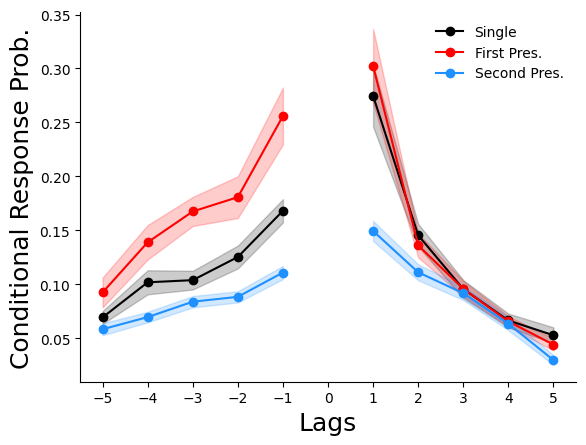

In [26]:
fix, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.plot(range(-5, 0), np.nanmean(CRP_sing, axis = 0)[12:17], color = 'k', marker='o')
plt.plot(range(-5, 0), np.nanmean(CRP_first, axis = 0)[12:17], color = 'red', marker='o')
plt.plot(range(-5, 0), np.nanmean(CRP_second, axis = 0)[12:17], color = 'dodgerblue', marker='o')
plt.legend(['Single', 'First Pres.','Second Pres.'], frameon = False)

plt.plot(range(1, 6), np.nanmean(CRP_sing, axis = 0)[18:23], color = 'k', marker='o')
plt.plot(range(1, 6), np.nanmean(CRP_first, axis = 0)[18:23], color = 'red', marker='o')
plt.plot(range(1, 6), np.nanmean(CRP_second, axis = 0)[18:23], color = 'dodgerblue', marker='o')

plt.xticks(range(-5,6))
plt.xlabel('Lags', fontsize = 18)
plt.ylabel('Conditional Response Prob.', fontsize = 18)

plt.fill_between(range(-5, 0), np.nanmean(CRP_sing, axis = 0)[12:17] - err_sing[12:17], np.nanmean(CRP_sing, axis = 0)[12:17] + err_sing[12:17], color = 'k', alpha = .2) 
plt.fill_between(range(-5, 0), np.nanmean(CRP_first, axis = 0)[12:17] - err_first[12:17], np.nanmean(CRP_first, axis = 0)[12:17] + err_first[12:17], color = 'red', alpha = .2) 
plt.fill_between(range(-5, 0), np.nanmean(CRP_second, axis = 0)[12:17] - err_second[12:17], np.nanmean(CRP_second, axis = 0)[12:17] + err_second[12:17], color = 'dodgerblue', alpha = .2) 

plt.fill_between(range(1, 6), np.nanmean(CRP_sing, axis = 0)[18:23] - err_sing[18:23], np.nanmean(CRP_sing, axis = 0)[18:23] + err_sing[18:23], color = 'k', alpha = .2) 
plt.fill_between(range(1, 6), np.nanmean(CRP_first, axis = 0)[18:23] - err_first[18:23], np.nanmean(CRP_first, axis = 0)[18:23] + err_first[18:23], color = 'red', alpha = .2) 
plt.fill_between(range(1, 6), np.nanmean(CRP_second, axis = 0)[18:23] - err_second[18:23], np.nanmean(CRP_second, axis = 0)[18:23] + err_second[18:23], color = 'dodgerblue', alpha = .2) 

In [11]:
def tempclust_bySubj(subj):
    df_select = df[(df['subject']==subj) & (df['experiment']==exp)]
    df_select = df_select[df_select.session < 7]
    nSess = len(df_select)

    temp_clust_first = []
    temp_clust_second = []
    

    for i in range(0, min([6, nSess])):

        sess_df = df_select.iloc[i]
        reader = cml.CMLReader(subject=sess_df.subject,
                       session=sess_df.session,
                       experiment=sess_df.experiment)
        evs = reader.load('task_events')
        word_evs = evs[evs['type']=='WORD']  
        recalled = np.array(word_evs.recalled)
        serial_pos = np.array(word_evs.serialpos)
        repeats = np.array(word_evs.repeats)

        enc_item = np.array(word_evs.item_num)
        enc_list = np.array(word_evs.list)

        rec_evs = evs[evs['type']=='REC_WORD'] 
        lists = np.array(rec_evs.list)
        repeats = np.array(rec_evs.repeats)
        rec_item =  np.array(rec_evs.item_num)


        for j in range(0, (max(rec_evs.list))):
            RecTime = np.array(rec_evs['rectime'][rec_evs['list'] == j])
            list_recs = rec_item[rec_evs['list'] == j]
            list_rep = repeats[rec_evs['list'] == j]
            encSP = serial_pos[enc_list == j]
            encwords = enc_item[enc_list == j]
            for k in range(len(list_recs)-1):
                if np.in1d(list_recs[k], list_recs[0:k]) or \
                np.in1d(list_recs[k+1], list_recs[0:k]) or \
                np.in1d(list_recs[k], encwords) == False or \
                np.in1d(list_recs[k+1], encwords) == False or \
                list_recs[k] < 0 and list_recs[k+1] < 0: #Check for repeats and intrusions
                    continue
                if list_rep[k] == 2:
                    first_SP = encSP[encwords == list_recs[k]][0]
                    second_SP = encSP[encwords == list_recs[k]][1]
                    SP_plusone = encSP[encwords == list_recs[k+1]]
                    
                    if len(SP_plusone) > 1:
                        first_SP_plusone = SP_plusone[np.where(min(abs(SP_plusone - first_SP)) == abs(SP_plusone - first_SP))[0][0]]
                        second_SP_plusone = SP_plusone[np.where(min(abs(SP_plusone - second_SP)) == abs(SP_plusone - second_SP))[0][0]]
                        actual_transitions_first = (first_SP_plusone - first_SP)
                        actual_transitions_second = (second_SP_plusone - second_SP)
                    else:
                        actual_transitions_first = (SP_plusone - first_SP)
                        actual_transitions_second = (SP_plusone - second_SP)
                    
                    not_yet_rec = encSP[np.in1d(encSP, encSP[0:k]) == False]
                    possible_transitions_first = np.array(abs(not_yet_rec - first_SP))
                    possible_transitions_second = np.array(abs(not_yet_rec - second_SP))
                    
                    nless_first =  sum(possible_transitions_first > abs(actual_transitions_first))
                    nequal_first = sum(possible_transitions_first == abs(actual_transitions_first))
                    temp_clust_first = np.append(temp_clust_first, (nless_first + .5*nequal_first)/ len(possible_transitions_first))

                    nless_second =  sum(possible_transitions_second > abs(actual_transitions_second))
                    nequal_second = sum(possible_transitions_second == abs(actual_transitions_second))
                    temp_clust_second = np.append(temp_clust_second, (nless_second + .5*nequal_second)/ len(possible_transitions_second))
                else:
                    single_SP = encSP[encwords == list_recs[k]][0]
                    SP_plusone = encSP[encwords == list_recs[k+1]]
                    
                    if len(SP_plusone) > 1:
                        SP_plusone = SP_plusone[np.where(min(abs(SP_plusone - single_SP)) == abs(SP_plusone - single_SP))[0][0]]

                    actual_transition = (SP_plusone- single_SP)
                    not_yet_rec = encSP[np.in1d(encSP, encSP[0:k]) == False]
                    possible_transitions = np.array(abs(not_yet_rec - single_SP))
                    
                    nless =  sum(possible_transitions > abs(actual_transition))
                    nequal = sum(possible_transitions == abs(actual_transition))


        

    return np.nanmean(temp_clust_first), np.nanmean(temp_clust_second)


In [12]:
TC_sing = [np.nan]* len(subjs)
TC_first = [np.nan]* len(subjs)
TC_second = [np.nan]* len(subjs)

for i in range(len(subjs)):
    try:
        TC_first[i], TC_second[i] =  tempclust_bySubj(subjs[i])
    except (FileNotFoundError, RuntimeError, TypeError, NameError, ValueError, AssertionError, IndexError, ZeroDivisionError):
        print("Error! Subject " + str(subjs[i]))
        continue

In [13]:
err_first = np.nanstd(TC_first)/math.sqrt(52)
err_second= np.nanstd(TC_second)/math.sqrt(52)
err_sing = np.nanstd(TC_sing)/math.sqrt(52)

err_first = err_first*1.96
err_second = err_second*1.96
err_sing = err_sing*1.96

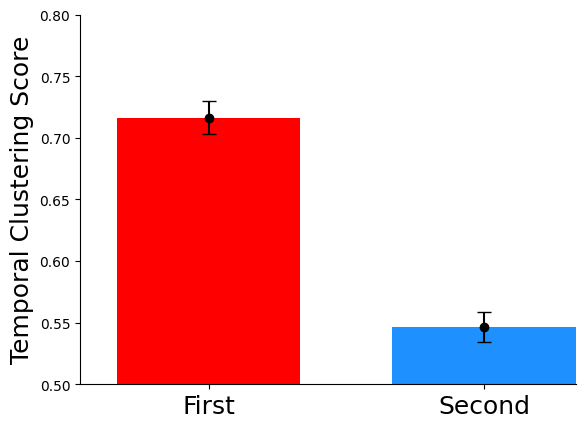

In [17]:
fix, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.bar([1], np.nanmean(TC_sing), color = [.5, .5, .5], width = 1)
# plt.errorbar([1], np.nanmean(TC_sing), yerr= err_sing, fmt="o", color="k", capsize = 5)

plt.bar([2.5], np.nanmean(TC_first), color = 'red' , width = 1)
plt.errorbar([2.5], [np.nanmean(TC_first)], yerr= err_first, fmt="o", color="k", capsize = 5)

plt.bar([4], np.nanmean(TC_second), color = 'dodgerblue', width = 1)
plt.errorbar([4], np.nanmean(TC_second), yerr= err_second, fmt="o", color="k", capsize = 5)


plt.xlim((1.8, 4.5))
plt.ylim((0.5, .8))
plt.ylabel("Temporal Clustering Score", fontsize = 18)
#plt.gca().set_yticks([.495, .499, .503, .507], labels = [.495, .499, .503, .507], fontsize = 12)
plt.gca().set_xticks([2.5, 4], labels = ['First', 'Second'], fontsize = 18)
